# Model Development

## Setup

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
print(os.getcwd())
print(sys.executable)

/Users/brianrice/dev/2021-msia423-rice-brian-project/notebooks/develop
/Users/brianrice/dev/2021-msia423-rice-brian-project/venv/bin/python


In [3]:
S3_BUCKET = "s3://2021-msia423-rice-brian"
S3_CLEANED_PATH = "cleaned/P4KxSpotify.csv"
IN_PATH = os.path.join(S3_BUCKET, S3_CLEANED_PATH)

SEED = 0

## Data prep

References:

- [Basic regression: Predict fuel efficiency](https://www.tensorflow.org/tutorials/keras/regression)

- [Classify structured data with feature columns](https://www.tensorflow.org/tutorials/structured_data/feature_columns)

In [4]:
df = pd.read_csv(IN_PATH)
df.head()

# Convert fields to the appropriate format
df["releaseyear"] = df["releaseyear"].astype("int64")
df["reviewdate"] = pd.to_datetime(df["reviewdate"])
# Number of days after the earliest in dataset:
# df["reviewdate"] = (df["reviewdate"] - df["reviewdate"].min()) / np.timedelta64(1, "D")

In [5]:
# Create train and test splits
train = df.sample(frac=0.8, random_state=SEED)
test = df.drop(train.index)

In [6]:
train.dtypes

artist                      object
album                       object
reviewauthor                object
score                      float64
releaseyear                  int64
reviewdate          datetime64[ns]
recordlabel                 object
genre                       object
danceability               float64
energy                     float64
key                        float64
loudness                   float64
speechiness                float64
acousticness               float64
instrumentalness           float64
liveness                   float64
valence                    float64
tempo                      float64
dtype: object

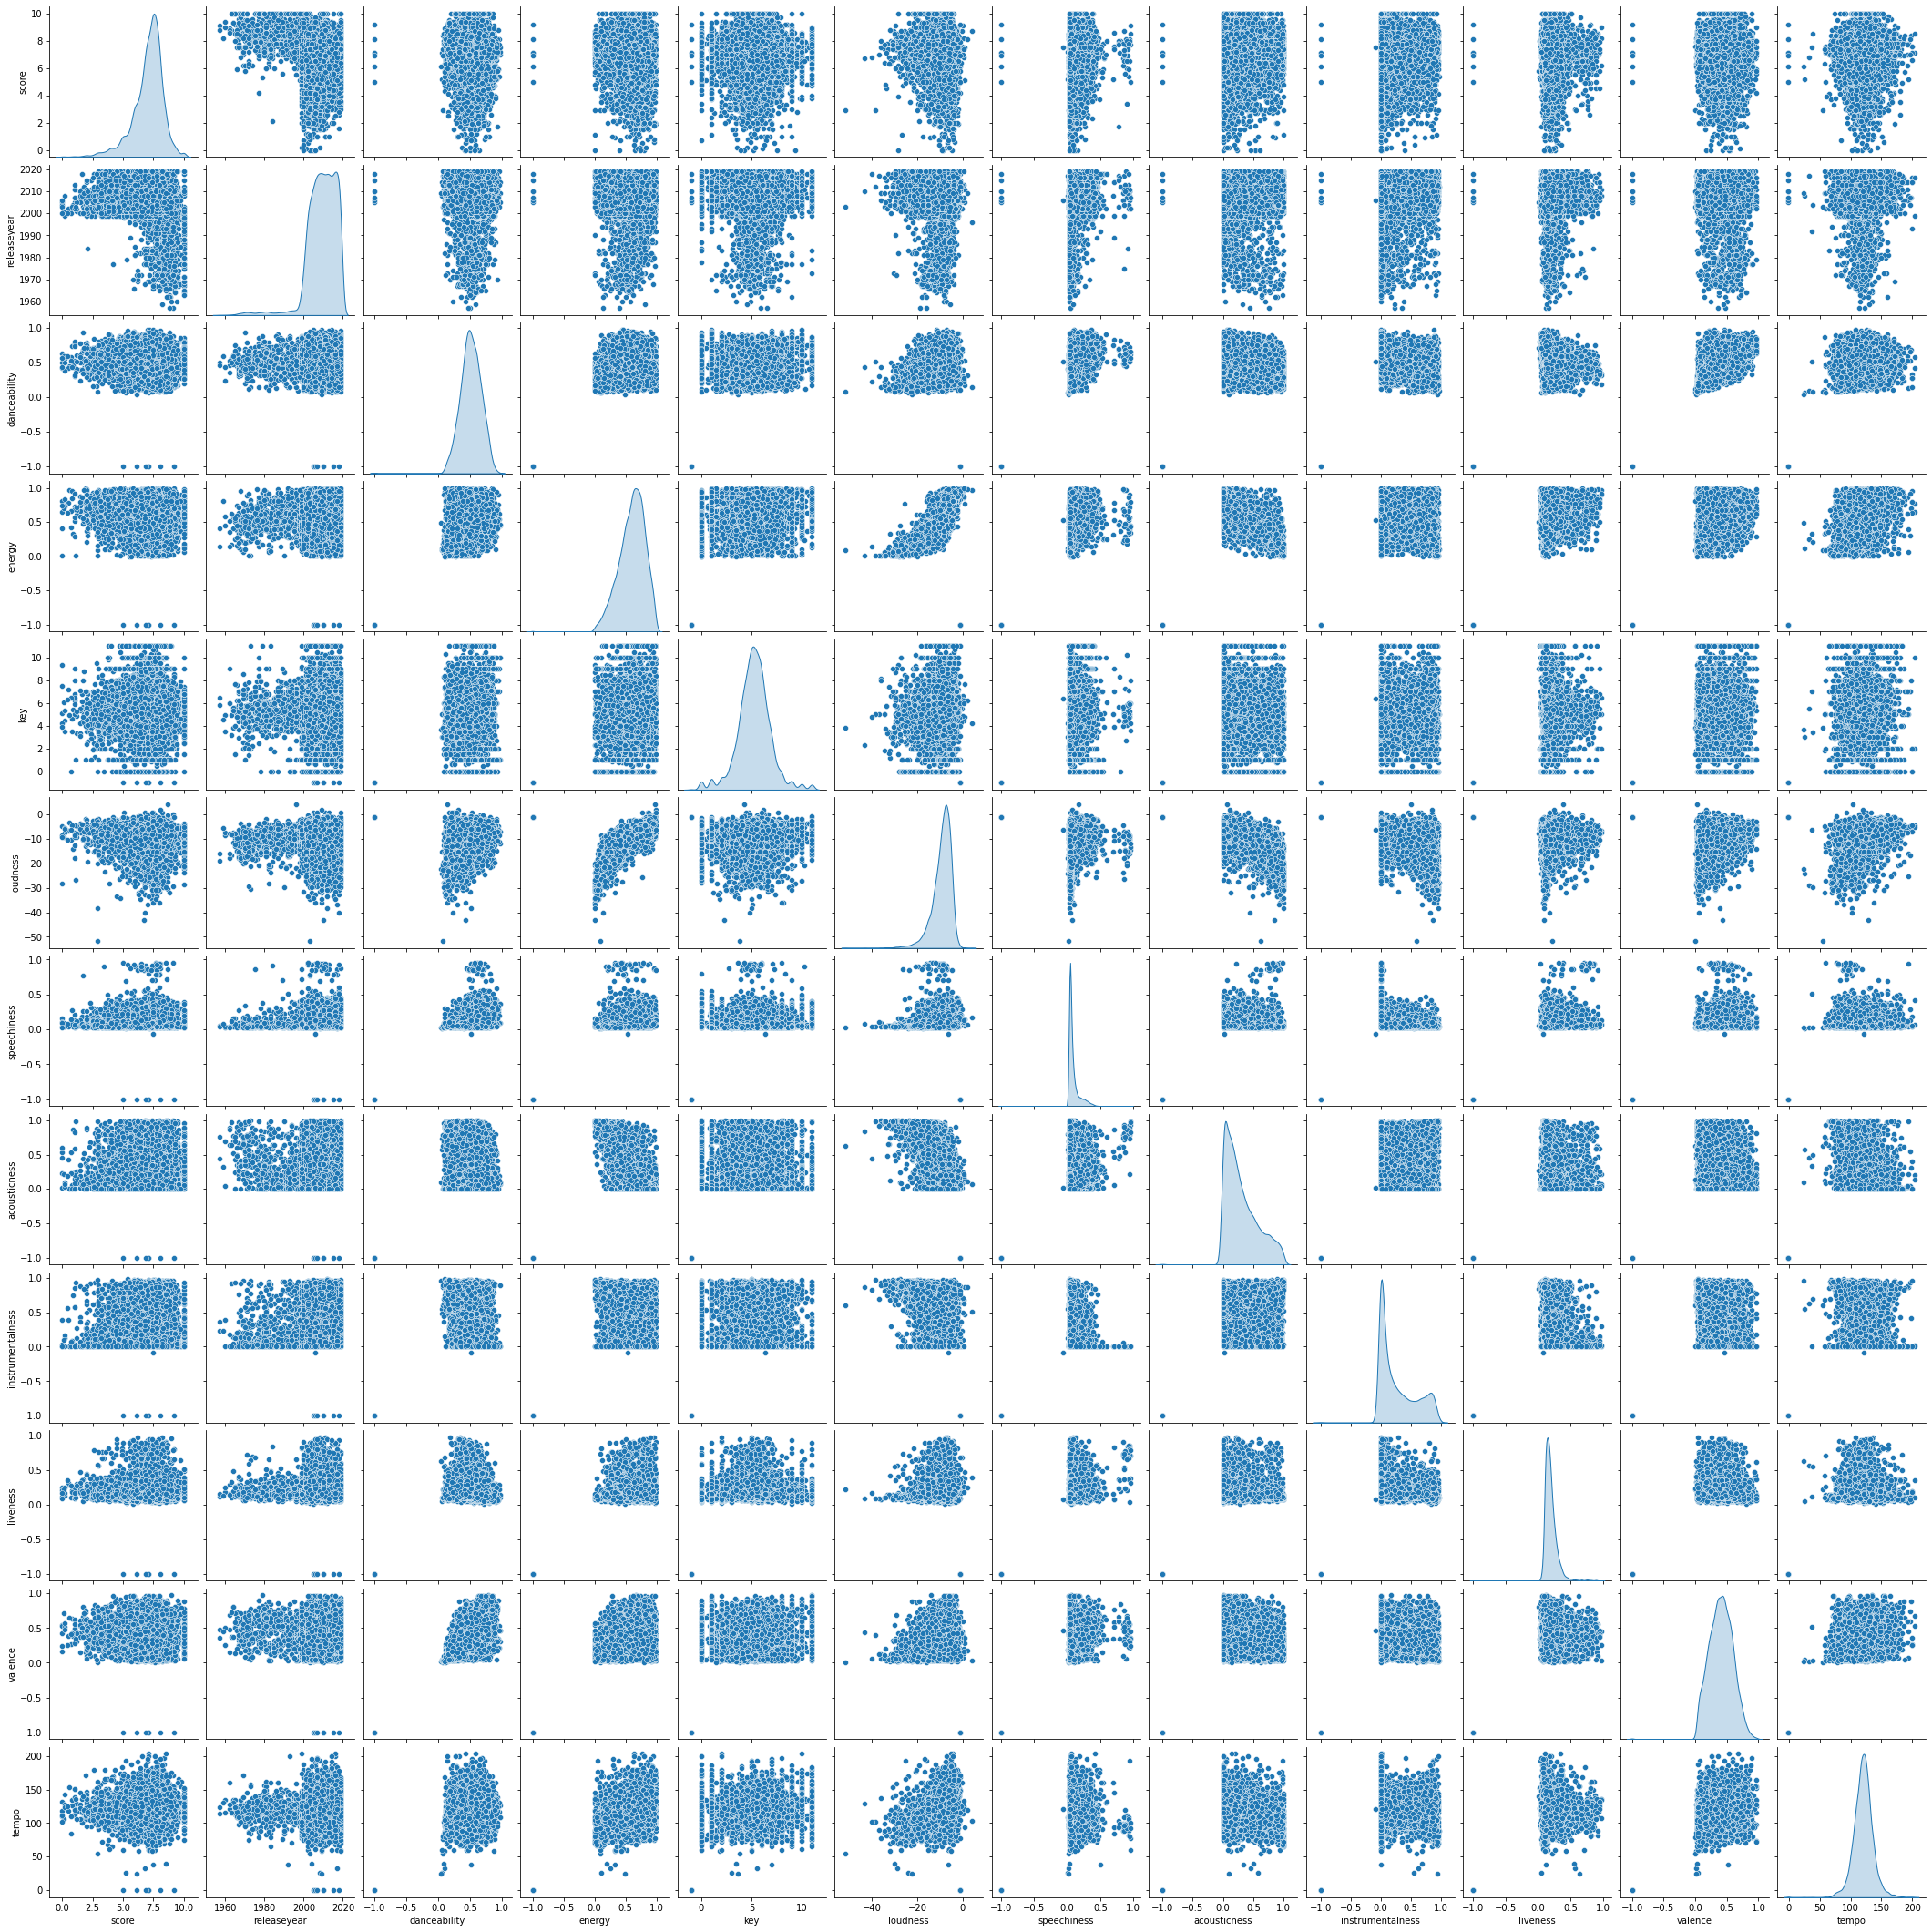

In [7]:
sns.pairplot(train, diag_kind="kde")

In [8]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
score,14722.0,7.038982,1.247713,0.00000,6.500000,7.300000,7.800000,10.000
releaseyear,14722.0,2009.157791,7.733321,1957.00000,2005.000000,2010.000000,2015.000000,2019.000
danceability,14722.0,0.510194,0.160003,-1.00000,0.405404,0.509512,0.621000,0.974
energy,14722.0,0.601152,0.204905,-1.00000,0.471723,0.624321,0.751975,0.999
key,14722.0,5.217750,1.629462,-1.00000,4.333333,5.233032,6.100000,11.000
loudness,14722.0,-9.312062,4.259247,-51.72875,-11.247522,-8.469933,-6.431301,4.078
speechiness,14722.0,0.091167,0.092820,-1.00000,0.040621,0.056871,0.100325,0.958
acousticness,14722.0,0.302518,0.264234,-1.00000,0.089026,0.228647,0.465493,0.996
instrumentalness,14722.0,0.279929,0.300650,-1.00000,0.010507,0.156358,0.509474,0.982
liveness,14722.0,0.196211,0.104470,-1.00000,0.134426,0.174378,0.228913,0.978


#### Split predictor and response variables

In [9]:
train_features = train.copy()
test_features = test.copy()

train_labels = train_features.pop("score")
test_labels = test_features.pop("score")

#### Normalization

In [10]:
train_numerical_features = np.array(train.loc[:, [
    "danceability", "key", "loudness", "speechiness",
    "acousticness", "instrumentalness", "liveness",
    "valence", "tempo"
]])
normalizer = preprocessing.Normalization()

# Calculate the mean and variance of each feature (if applicable)
normalizer.adapt(np.array(train_numerical_features))
normalizer.mean.numpy()

array([ 5.1019418e-01,  5.2177505e+00, -9.3120613e+00,  9.1166541e-02,
        3.0251798e-01,  2.7992889e-01,  1.9621089e-01,  4.0339702e-01,
        1.2028120e+02], dtype=float32)

In [11]:
indexer = preprocessing.IntegerLookup()
indexer.adapt(np.array(train_features["releaseyear"]))

In [12]:
# One-hot encode categorical features too
train_categorical_features = np.array(train["genre"])
indexer = preprocessing.StringLookup()
indexer.adapt(np.array(train_categorical_features))

## Modeling

In [13]:
# Linear regression
numerical_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])
numerical_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=5e-2),
    loss="mse"
)

In [14]:
history = numerical_model.fit(
    train_numerical_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2
)

In [16]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail(10)

,loss,val_loss,epoch
90,1.605885,1.513949,90
91,1.603661,1.564499,91
92,1.599094,1.519064,92
93,1.604247,1.502964,93
94,1.590913,1.546926,94
95,1.608153,1.588417,95
96,1.594174,1.556856,96
97,1.599400,1.536891,97
98,1.598685,1.561693,98
99,1.613787,1.507137,99


In [17]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

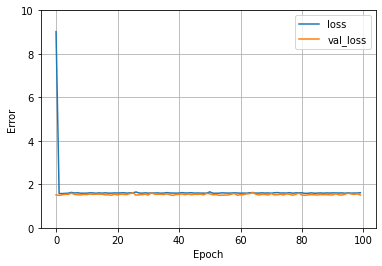

In [18]:
plot_loss(history)